# Pointer Generator Model

In [1]:
import torch
from NewsroomHelper import get_newsroom_datasets
from models import Summarizer
from model_helpers import loss_function, error_function
from utils import produce_attention_visualization_file, summarize, get_text_triplets, produce_summary_files, run_rouge
from pytorch_helper import ModelManipulator, plot_learning_curves

## Parameters

In [2]:
# training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 1
LEARNING_RATE = 1e-2
# INITIAL_ACCUMULATOR_VALUE = 0.1
GAMMA = 1
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
BEAM_SIZE = 4

True


## Get Data

In [3]:
newsroom_dataset_train, newsroom_dataset_dev, newsroom_dataset_test, preprocessor = get_newsroom_datasets(with_oov=True)
word_vectors = preprocessor.word_vectors
start_index = preprocessor.word_indices['<start>']
end_index = preprocessor.word_indices['<end>']

74342 8272 8272
retrieving word2vec model from file


## Create Model

In [4]:
pointer_generator_model = Summarizer(preprocessor, start_index, end_index, num_hidden1=None, num_hidden2=None, with_coverage=True, gamma=GAMMA, with_pointer=True)

## Train and Save Model

In [5]:
optimizer = torch.optim.Adam(pointer_generator_model.parameters(),
                             lr=LEARNING_RATE)
# optimizer = torch.optim.Adagrad((pointer_generator_model.cuda() if USE_CUDA else pointer_generator_model).parameters(),
#                                 lr=LEARNING_RATE, initial_accumulator_value=INITIAL_ACCUMULATOR_VALUE)
model_manip = ModelManipulator(pointer_generator_model, optimizer, loss_function, error_function, use_cuda=USE_CUDA)
train_stats, val_stats = model_manip.train(newsroom_dataset_train, BATCH_SIZE, NUM_EPOCHS, dataset_val=newsroom_dataset_dev, stats_every=10, verbose_every=10, checkpoint_every=10, checkpoint_path='checkpoint', restart=False)

epoch: 0, batch: 0, train_loss: 245.838715, train_error: None
1 epochs with 8 batches per epoch done


## Plot

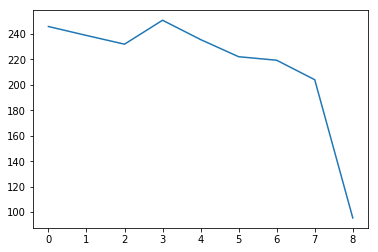

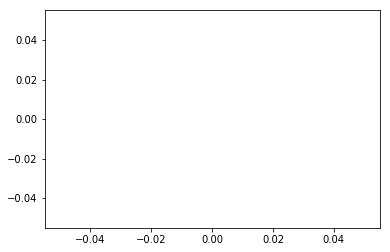

In [6]:
plot_learning_curves(training_values=train_stats, validation_values=val_stats, figure_name='graphs/pointer_generator_training_temp')

In [7]:
batch = newsroom_dataset_dev[0:1]
results = summarize(batch, pointer_generator_model, beam_size=BEAM_SIZE)

In [8]:
summary_info = results[0]
triplets = get_text_triplets(batch, summary_info, preprocessor, pointer_gen=True)
for i,(text, reference_summary, decoded_summary) in enumerate(triplets):
    loss = summary_info[2][i]
    print("text", text)
    print("reference summary", reference_summary)
    print("decoded summary", decoded_summary)
    print(loss)

text ['<start>', 'tuesday', ',', 'march', 'qqq', ',', 'qqq', ',', 'qqq', 'pm', 'apple', "'s", 'ceo', 'tim', 'cook', 'finally', 'revealed', 'the', 'tech', 'specs', 'for', 'the', 'highly', 'anticipated', 'apple', 'watch', 'monday', 'in', 'san', 'francisco', ',', 'when', 'he', 'announced', 'the', 'smartwatch', 'will', 'begin', 'shipping', 'april', 'qqq', 'and', 'starts', 'at', '$', 'qqq', '.', 'the', 'apple', 'watch', 'will', 'come', 'in', 'two', 'different', 'retina', 'displays', ',', 'qqq', 'and', 'qqq', ',', 'and', 'it', "'ll", 'have', 'a', 'battery', 'that', 'lasts', 'up', 'to', 'qqq', 'hours', '.', 'the', 'watch', 'will', 'also', 'come', 'in', 'four', 'different', 'colors', 'and', 'three', 'different', 'models', ':', 'apple', 'watch', 'sport', ',', 'apple', 'watch', 'and', 'apple', 'watch', 'edition', '.', 'compared', 'to', 'other', 'watches', 'like', 'the', 'samsung', 'gear', 's', 'and', 'the', 'moto', 'qqq', ',', 'the', 'apple', 'watch', 'is', 'capable', 'of', 'doing', 'the', 'same

In [9]:
summary_info = results[0]
i = 0

triplets = get_text_triplets(batch, summary_info, preprocessor)

text, reference_summary, decoded_summary = triplets[i]
attentions, p_gens = [[float(f) for f in vector[1:-1]] for vector in summary_info[4][i][:-1]], [float(f) for f in summary_info[5][i][:-1]]

produce_attention_visualization_file('graphs/attn_vis_data.json', text, " ".join(reference_summary), decoded_summary, attentions, p_gens)

In [10]:
produce_summary_files(newsroom_dataset_train, 5, pointer_generator_model, "rouge", beam_size=BEAM_SIZE)

0
1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
df = run_rouge()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df[df['ROUGE-Type'] == 'ROUGE-L+StopWordRemoval']['Avg_F-Score']*100)